# تشخیص محصولات باغی خراب از سالم با استفاده از شبکه‌های عصبی CNN 
 در این notebook تلاش می‌کنیم تا با در ابتدا با دیتای عکسی و نحوه استفاده از آن برای طبقه‌بندی آشنا شویم و سپس با استفاده از framework کراس یک شبکه عصبی کوچک برای تشخیص محصول سالم از غیر سلام استفاده می‌کنیم. نتایج این notebook در مقابل نتایج استفاده از  SVM بر روی همین داده قرار می‌گیرد.





1.  ابتدا داده را دانلود میکنیم و در پوشه‌ای به همان نام قرار می‌دهیم.



In [0]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git
!mkdir input
!cp -r PlantVillage-Dataset/raw/color/* ./input
!rm -rf PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 33.71 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.



2.    برای پیش‌پردازش و طراحی شبکه کتابخانه‌های لازم را import می‌کنیم.



In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



3.   حال تعدادی از پارامتر‌های مساله را ثابت می‌کنیم. این پارامترها شامل تعداد گردش الگوریتم، نرخ یادگیری، سایز بسته‌های یادگیری، سایز عکس و ... می‌باشد.



In [0]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'input'
width=256
height=256
depth=3



4.  تابع زیر تلاش می‌کند که یک عکس را از روی دیسک بخواند و آنرا تبدیل به یک آرایه بکند.

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None





5.   در زیر تلاش می‌کنیم تا هر عکس را در دایرکتوری مربوط به خودش بخوانیم و عکس را با استفاده از تابع بالا به آرایه تبدیل می‌کنیم و از نام دایرکتوری‌ش به آن لیبلی می‌دهیم.



In [0]:
image_list, label_list ,image_list_fs = [], [] , []
print("[INFO] Loading images ...")
root_dir = listdir(directory_root)
for directory in root_dir :
    # remove .DS_Store from list
    if directory == ".DS_Store" :
        root_dir.remove(directory)

for plant_folder in root_dir[:10] :
        print('[INFO] Loading {}'.format(plant_folder))
        plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}")
        for single_plant_disease_image in plant_disease_image_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_image_list.remove(single_plant_disease_image)

        for image in plant_disease_image_list[:200]:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                image_list_fs.append(cv2.imread(image_directory))
                label_list.append(plant_folder)
print("[INFO] Image loading completed")  


[INFO] Loading images ...
[INFO] Loading Strawberry___healthy
[INFO] Loading Potato___healthy
[INFO] Loading Raspberry___healthy
[INFO] Loading Potato___Late_blight
[INFO] Loading Blueberry___healthy
[INFO] Loading Tomato___Tomato_Yellow_Leaf_Curl_Virus
[INFO] Loading Tomato___Spider_mites Two-spotted_spider_mite
[INFO] Loading Cherry_(including_sour)___healthy
[INFO] Loading Pepper,_bell___Bacterial_spot
[INFO] Loading Tomato___Late_blight
[INFO] Image loading completed


In [0]:
image_size = len(image_list)



6.  حال با استفاده از LabelBinarizer تلاش می‌کنیم برچسب‌های داده را به عدد نسبت دهیم.




In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
print(label_binarizer.classes_)

['Blueberry___healthy' 'Cherry_(including_sour)___healthy'
 'Pepper,_bell___Bacterial_spot' 'Potato___Late_blight' 'Potato___healthy'
 'Raspberry___healthy' 'Strawberry___healthy' 'Tomato___Late_blight'
 'Tomato___Spider_mites Two-spotted_spider_mite'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']




7.   حال تمامی مقادیر داخل آرایه را به عدد بین 0 و 1 اسکیل می‌کنیم.



In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0



8.   سپس داده را به دو بخش تست و ترین تقسیم می‌کنیم. 



In [0]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test




9.   حال با استفاده از ImageDataGenerator می‌خواهیم یک پایپ لاین از دیتای عکس به یک تابعی برای افزایش دیتا بسازیم.



In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")



10.   حال شبکه عصبی مورد نظر را طراحی می‌کنیم. شبکه عصبی زیر شامل 5 لایه کانوولوشن برای به دست آوردن feature map های مورد نیاز میباشد. این شبکه خیلی ساده است و برای طراحی شبکه‌های پیچیده‌تر مثل resnet و ... از همین تمپلیت 5 کانوولوشنی استفاده شده‌است.



In [0]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
activation_15 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_16 (Activation)   (None, 85, 85, 64)        0         
__________





11.   حال با آماده بودن دیتا و شبکه، کار ترین را آغاز می‌کنیم.



In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

W0823 08:27:20.897092 140017798322048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
48/48 [==============================] - 33s 695ms/step - loss: 1.4688 - acc: 0.5690 - val_loss: 5.5691 - val_acc: 0.2890
Epoch 2/25
48/48 [==============================] - 27s 560ms/step - loss: 0.8842 - acc: 0.7497 - val_loss: 2.6877 - val_acc: 0.5192
Epoch 3/25
48/48 [==============================] - 27s 556ms/step - loss: 0.6206 - acc: 0.8056 - val_loss: 2.1585 - val_acc: 0.5882
Epoch 4/25
48/48 [==============================] - 27s 557ms/step - loss: 0.6268 - acc: 0.8053 - val_loss: 1.9712 - val_acc: 0.6726
Epoch 5/25
48/48 [==============================] - 27s 555ms/step - loss: 0.6015 - acc: 0.8137 - val_loss: 5.4106 - val_acc: 0.3683
Epoch 6/25
48/48 [==============================] - 27s 555ms/step - loss: 0.5435 - acc: 0.8288 - val_loss: 1.7318 - val_acc: 0.6701
Epoch 7/25
48/48 [==============================] - 27s 557ms/step - loss: 0.5150 - acc: 0.8422 - val_loss: 4.4547 - val_acc: 0.4834
Epoch 8/25
48/48 [==============================] - 27s 558ms/step - 




12.   در نهایت نتایج را رسم می‌کنیم و درصد دقت را بررسی می‌کنیم.



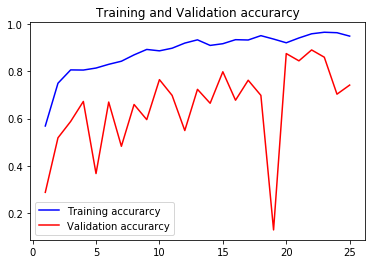

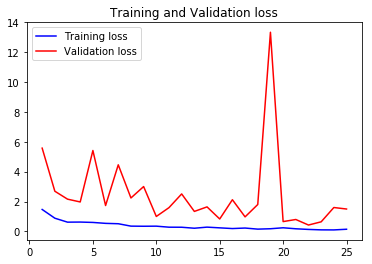

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
391/391 [==============================] - 2s 4ms/step
Test Accuracy: 74.16879799969665


In [0]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...







13.   تکه کد زیر برای نشان دادن عکس‌ها استفاده می‌شود



In [0]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(2, 2)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1        

Strawberry___healthy


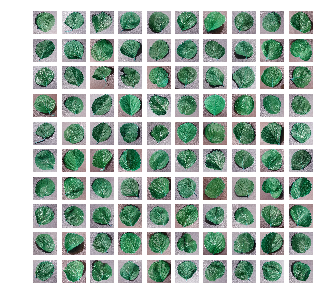

In [0]:
print(label_list[0])
plot_image_grid(image_list_fs[0:100], 10, 10)